In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.splits import create_splits_scenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from einops import rearrange, repeat
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection

import sys
sys.path.append('/home/wxd/video-generation/diffusers/src')

from diffusers.models.unet_action_v02 import UNetSpatioTemporalConditionModel_Action
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers import ActionVideoDiffusionPipeline

In [2]:
pretrained_model_name_or_path = '/ssd_datasets/wxiaodong/ckpt/drive-video-s256-v02-ep100'
text_encoder = CLIPTextModel.from_pretrained(
            pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
            pretrained_model_name_or_path, subfolder="vae"
)

text_encoder.eval()
vae.eval()
text_encoder.to('cuda:2')
vae.to('cuda:2')

tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")
scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
feature_extractor = CLIPImageProcessor.from_pretrained(pretrained_model_name_or_path, subfolder="feature_extractor")

In [3]:
unet = UNetSpatioTemporalConditionModel_Action.from_pretrained(pretrained_model_name_or_path, subfolder="unet")
unet.eval()
unet = unet.to('cuda:2')

add image context parameters
add image context parameters
add image context parameters
add image context parameters
add image context parameters


In [4]:
pipeline = ActionVideoDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            scheduler=scheduler,
            tokenizer=tokenizer,
            feature_extractor=feature_extractor
)

In [5]:
pipeline.to('cuda:2')

ActionVideoDiffusionPipeline {
  "_class_name": "ActionVideoDiffusionPipeline",
  "_diffusers_version": "0.25.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNetSpatioTemporalConditionModel_Action"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
### test examples
import os
files = os.listdir('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames')

In [7]:
from transformers import AutoProcessor, AutoModelForCausalLM
git_processor_large = AutoProcessor.from_pretrained("/ssd_datasets/wxiaodong/ckpt/git-large-coco")
git_model_large = AutoModelForCausalLM.from_pretrained("/ssd_datasets/wxiaodong/ckpt/git-large-coco")

In [8]:
git_model_large.to('cuda:2')
def generate_caption(image):
    pil_list = [image.convert('RGB')]
    inputs = git_processor_large(images=pil_list, return_tensors="pt").to('cuda:2')
    
    generated_ids = git_model_large.generate(pixel_values=inputs.pixel_values, max_length=50)

    generated_caption = git_processor_large.batch_decode(generated_ids, skip_special_tokens=True)
   
    return generated_caption[0]

n008-2018-08-31-11-37-23-0400__CAM_FRONT__1535730420912404.jpg
a truck and a truck are parked on the street.
torch.Size([1, 8])


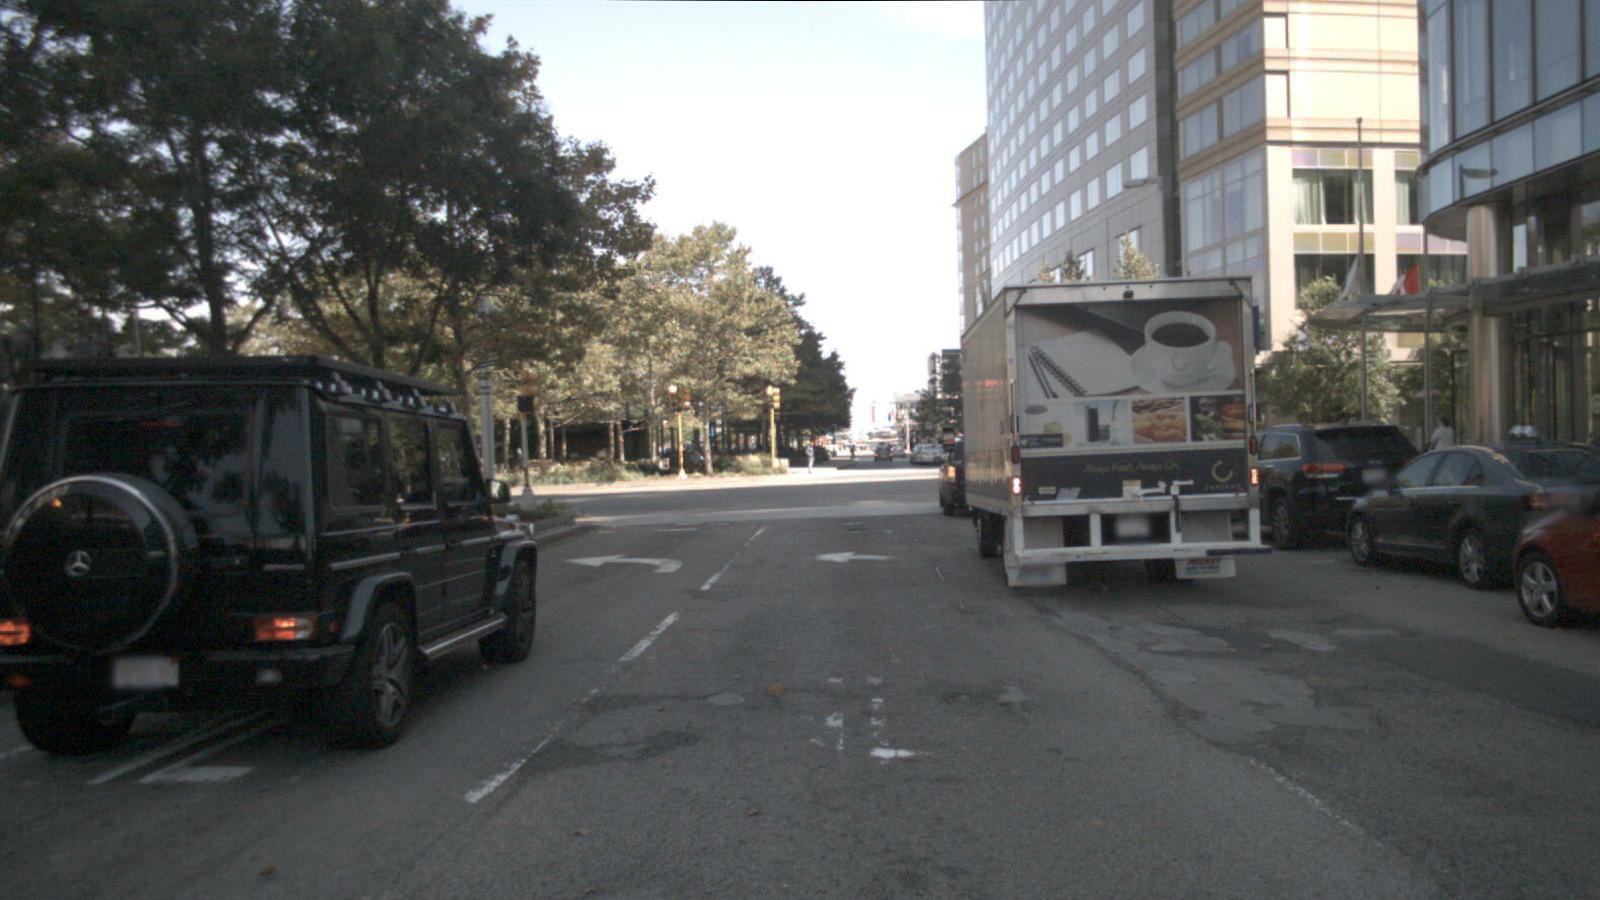

In [24]:
from PIL import Image
import numpy as np

file_idx = 30
image_path = os.path.join('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames', files[file_idx])
print(files[file_idx])
image = Image.open(image_path)
prompt = generate_caption(image)
# prompt = "some cars are driving on a street surrounded by trees."
print(prompt)

action_scale = 1
steers = [[17.59999999999991,
 14.299999999999727,
 14.299999999999727,
 14.299999999999727,
 16.799999999999727,
 18.0,
 19.699999999999818,
 23.0]]
speeds = [[22.17,
 21.29,
 20.38,
 19.48,
 19.03,
 19.150000000000002,
 19.740000000000002,
 20.59]]
# steers = torch.zeros((8, 1))
# speeds = torch.zeros((8, 1))
         
steers = torch.tensor(steers) * np.pi / 180 * action_scale
speeds = torch.tensor(speeds) * 10. / 36 * action_scale
print(steers.shape)

steers = steers.view(-1, 1)
speeds = speeds.view(-1, 1)
action = torch.cat([steers, speeds], dim=-1)
action = action.to('cuda:2')
image

In [25]:
frames = pipeline(image,num_frames=8, prompt=prompt, action=action, height=256, width=512).frames[0]

text emb shape:  torch.Size([1, 77, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context shape torch.Size([1, 8, 768])
check time_context s

In [26]:
#save first 8 frames
frames[0] = image.resize((512, 256)).convert('RGB')
frames[0]
# default saving method in diffusers
from diffusers.utils import export_to_video
export_to_video(frames, f"generated_val_{file_idx}_s256_8f_textaction.mp4", fps=6)

'generated_val_30_s256_8f_textaction.mp4'